Instala bibliotecas e Imports

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    !pip install datasets --quiet
    !pip install peft --quiet
    !pip install trl --quiet
    !pip install bitsandbytes --quiet

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import numpy as np
import pandas as pd
import os
import sys
import os
from tqdm import tqdm
import json
import torch
sys.path.append(".")
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
from transformers import Trainer
import seaborn as sns
from matplotlib import pyplot as plt
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.nn import CrossEntropyLoss

import warnings
warnings.filterwarnings("ignore")

In [5]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
if IN_COLAB:
    mkdir = lambda x: os.system(f"mkdir -p {x}")
    mkdir('/content/drive/MyDrive/Curso_IA/modulo_2')
    %cd /content/drive/MyDrive/Curso_IA/modulo_2

/content/drive/MyDrive/Curso_IA/modulo_2


Carregamento dos datasets e formatação dos dados

In [7]:
%pwd

'/content/drive/MyDrive/Curso_IA/modulo_2'

In [8]:
def boolq_format_func(sample):
    response = str(int(sample['answer'])) if isinstance(sample['answer'], bool) else sample['answer']
    sample["Text"] = f"Passage: {sample['passage']} Question: {sample['question']}### Response:\n{response}"
    return sample

def agnews_format_func(sample):
    label = sample["label"] - 1
    sample["Text"] = f"Title: {sample['title']} Description: {sample['description']}### Response:\n{sample['label']}"
    return sample

def sql_format_func(sample):
    sample["Text"] = f"### SQL Prompt:\n{sample['sql_prompt']}\n### Response:\n{sample['sql']}"
    return sample

boolq_dataset = load_dataset("google/boolq")
boolq_dataset = boolq_dataset.map(boolq_format_func)

agnews_dataset = load_dataset("sh0416/ag_news")
agnews_dataset = agnews_dataset.map(agnews_format_func)

sql_dataset = load_dataset("gretelai/synthetic_text_to_sql")
sql_dataset = sql_dataset.map(lambda x: sql_format_func(x))

In [9]:
print(boolq_dataset['train'][0])
print(agnews_dataset['train'][0])
print(sql_dataset['train'][0])

{'question': 'do iran and afghanistan speak the same language', 'answer': True, 'passage': 'Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.', 'Text': 'Passage: Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikista

Configuração do Modelo e QLoRA

In [10]:
model_name = 'HuggingFaceTB/SmolLM-1.7B'
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

Tokenização e pre-processamento dos datasets

In [11]:
boolq_dataset = boolq_dataset.map(lambda samples: tokenizer(samples['Text']), batched=True)
agnews_dataset = agnews_dataset.map(lambda samples: tokenizer(samples['Text']), batched=True)
sql_dataset = sql_dataset.map(lambda samples: tokenizer(samples['Text']), batched=True)

Quantização do modelo, utilizando adapters especializados para cada dataset:

1. google/boolq - Tarefa de classificação de sequências
2. sh0416/ag_news - Tarefa de classificação de sequências
3. gretelai/synthetic_text_to_sql - Tarefa de geração de sequência-a-sequência

In [12]:
peft_config_goog = LoraConfig(
    r=8,  # Low-rank dimension for LoRA matrices
    lora_alpha=16,  # Scaling factor for LoRA updates
    lora_dropout=0.1,  # Dropout for regularization
    bias="none",  # No additional bias terms
    target_modules=["q_proj", "v_proj"],  # Target attention layers
    task_type="SEQ_CLS"  # Sequence classification task
)

peft_config_ag = LoraConfig(
    r=8,  # Low-rank dimension for LoRA matrices
    lora_alpha=16,  # Scaling factor for LoRA updates
    lora_dropout=0.1,  # Dropout for regularization
    bias="none",  # No additional bias terms
    target_modules=["q_proj", "v_proj"],  # Target attention layers
    task_type="SEQ_CLS"  # Sequence classification task
)

peft_config_sql = LoraConfig(
    r=4,  # Low-rank dimension for LoRA matrices
    lora_alpha=32,  # Scaling factor for LoRA updates
    lora_dropout=0.1,  # Dropout for regularization
    bias="none",  # No additional bias terms
    target_modules=["q_proj", "v_proj", "out_proj"],  # Target attention and output layers
    task_type="SEQ_2_SEQ_LM"  # Sequence-to-sequence language modeling task
)

Treinamento independente dos Adapters

In [13]:
max_steps = 20

q_args = SFTConfig(
    output_dir="output/Qlora",         # directory to save and repository id
    max_seq_length=512,                     # max sequence length for model and packing of the dataset
    packing=True,                           # Groups multiple samples in the dataset into a single sequence
    max_steps=max_steps,                    # max number of training steps
    per_device_train_batch_size=2,          # batch size per device during training
    gradient_accumulation_steps=4,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="paged_adamw_8bit",               # paged adamw optimizer for training
    logging_steps=int(max_steps/10),        # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    dataset_kwargs={
        "add_special_tokens": False, # We template with special tokens
        "append_concat_token": True, # Add EOS token as separator token between examples
    },
    report_to='none',
    dataset_text_field = 'Text',
)

In [14]:
from peft import prepare_model_for_kbit_training

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_storage=torch.bfloat16
)

model_q = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quant_config)
model_q.gradient_checkpointing_enable()
model_q = prepare_model_for_kbit_training(model_q)
model_q = get_peft_model(model_q, peft_config_goog)
model_q.print_trainable_parameters()

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 1,572,864 || all params: 1,712,949,248 || trainable%: 0.0918


In [15]:
response_temp = '### Response:\n'
response_temp_ids = tokenizer(response_temp)['input_ids']
data_collator = DataCollatorForCompletionOnlyLM(response_temp_ids, tokenizer = tokenizer)

q_args.output_dir="output/Qlora/boolq"

model_q = model_q.to('cuda')
q_trainer = Trainer(
    model=model_q,
    args=q_args,
    train_dataset=boolq_dataset["train"],
    data_collator=data_collator
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


1. Fine-tuning para o dataset google/boolq

In [16]:
start = time.time()
q_trainer.train()
print(f"Training time: {time.time()-start} seconds")
print(f"Peak memory usage: {torch.cuda.max_memory_allocated() / 1024**3} GB")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
2,5.721500
4,5.230400
6,5.298900
8,4.601400
10,4.966100
12,3.781700
14,4.020900
16,3.157800
18,2.750600
20,1.773600


Training time: 171.14753890037537 seconds
Peak memory usage: 2.1009254455566406 GB


2. Fine-tuning para o dataset sh0416/ag_news

In [17]:
del model_q, q_trainer
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

In [18]:
model_q = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quant_config)
model_q.gradient_checkpointing_enable()
model_q = prepare_model_for_kbit_training(model_q)
model_q = get_peft_model(model_q, peft_config_ag)
model_q.print_trainable_parameters()

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 1,572,864 || all params: 1,712,949,248 || trainable%: 0.0918


In [19]:
response_temp = '### Response:\n'
response_temp_ids = tokenizer(response_temp)['input_ids']
data_collator = DataCollatorForCompletionOnlyLM(response_temp_ids, tokenizer = tokenizer)

q_args.output_dir="output/Qlora/agnews"

model_q = model_q.to('cuda')
q_trainer = Trainer(
    model=model_q,
    args=q_args,
    train_dataset=agnews_dataset["train"],
    data_collator=data_collator
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [20]:
start = time.time()
q_trainer.train()
print(f"Training time: {time.time()-start} seconds")
print(f"Peak memory usage: {torch.cuda.max_memory_allocated() / 1024**3} GB")

Step,Training Loss
2,4.955300
4,5.035000
6,4.797300
8,4.635200
10,4.179600
12,4.000200
14,3.715200
16,3.126700
18,2.948500
20,2.461800


Training time: 92.42400121688843 seconds
Peak memory usage: 2.508085250854492 GB


3. Fine-tuning para o dataset gretelai/synthetic_text_to_sql

In [21]:
del model_q, q_trainer
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

In [22]:
model_q = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quant_config)
model_q.gradient_checkpointing_enable()
model_q = prepare_model_for_kbit_training(model_q)
model_q = get_peft_model(model_q, peft_config_ag)
model_q.print_trainable_parameters()

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 1,572,864 || all params: 1,712,949,248 || trainable%: 0.0918


In [23]:
response_temp = '### Response:\n'
response_temp_ids = tokenizer(response_temp)['input_ids']
data_collator = DataCollatorForCompletionOnlyLM(response_temp_ids, tokenizer = tokenizer)

q_args.output_dir="output/Qlora/sql"

model_q = model_q.to('cuda')
q_trainer = Trainer(
    model=model_q,
    args=q_args,
    train_dataset=sql_dataset["train"],
    data_collator=data_collator
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [24]:
start = time.time()
q_trainer.train()
print(f"Training time: {time.time()-start} seconds")
print(f"Peak memory usage: {torch.cuda.max_memory_allocated() / 1024**3} GB")

Step,Training Loss
2,0.815200
4,0.951200
6,0.938300
8,1.087500
10,1.046500
12,0.853900
14,0.804500
16,0.865500
18,0.602000
20,0.684900


Training time: 95.16208076477051 seconds
Peak memory usage: 2.508085250854492 GB


Modificando o parâmetro R

In [25]:
q_trainer.state.log_history[-2]['loss']

0.6849

In [26]:
peft_config_goog = LoraConfig(
    r=8,  # Low-rank dimension for LoRA matrices
    lora_alpha=16,  # Scaling factor for LoRA updates
    lora_dropout=0.1,  # Dropout for regularization
    bias="none",  # No additional bias terms
    target_modules=["q_proj", "v_proj"],  # Target attention layers
    task_type="SEQ_CLS"  # Sequence classification task
)


model_q = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quant_config)
model_q.gradient_checkpointing_enable()
model_q = prepare_model_for_kbit_training(model_q)
model_q = get_peft_model(model_q, peft_config_goog)
model_q.print_trainable_parameters()

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 1,572,864 || all params: 1,712,949,248 || trainable%: 0.0918


In [27]:
model_q.get_nb_trainable_parameters()

(1572864, 1712949248)

In [28]:
total_trainable_params, all_params = model_q.get_nb_trainable_parameters()
trainable = (total_trainable_params / all_params)*100
print(f"Total trainable parameters: {total_trainable_params}")
print(f"Total parameters: {all_params}")
print(f"Trainable percentage: {trainable:.4}%")

Total trainable parameters: 1572864
Total parameters: 1712949248
Trainable percentage: 0.09182%


In [29]:
list(range(8,33,8))

[8, 16, 24, 32]

In [30]:
ranks = range(8,33,8)
parameters = []
losses = []

for rank in ranks:
  del model_q, q_trainer
  torch.cuda.reset_peak_memory_stats()
  torch.cuda.empty_cache()

  peft_config_goog = LoraConfig(
      r=rank,  # Low-rank dimension for LoRA matrices
      lora_alpha=16,  # Scaling factor for LoRA updates
      lora_dropout=0.1,  # Dropout for regularization
      bias="none",  # No additional bias terms
      target_modules=["q_proj", "v_proj"],  # Target attention layers
      task_type="SEQ_CLS"  # Sequence classification task
  )



  model_q = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quant_config)
  model_q.gradient_checkpointing_enable()
  model_q = prepare_model_for_kbit_training(model_q)
  model_q = get_peft_model(model_q, peft_config_goog)

  total_trainable_params, all_params = model_q.get_nb_trainable_parameters()
  parameters.append(total_trainable_params)


  response_temp = '### Response:\n'
  response_temp_ids = tokenizer(response_temp)['input_ids']
  data_collator = DataCollatorForCompletionOnlyLM(response_temp_ids, tokenizer = tokenizer)

  q_args.output_dir="output/Qlora/graphic"

  model_q = model_q.to('cuda')
  q_trainer = Trainer(
      model=model_q,
      args=q_args,
      train_dataset=boolq_dataset["train"],
      data_collator=data_collator
  )

  q_trainer.train()

  losses.append(q_trainer.state.log_history[-2]['loss'])

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
2,5.714800
4,5.230800
6,5.305200
8,4.613200
10,4.950900
12,3.757200
14,4.006000
16,3.126000
18,2.709000
20,1.698500


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
2,5.734000
4,5.236100
6,5.320000
8,4.601500
10,4.960400
12,3.770000
14,4.008500
16,3.144800
18,2.759400
20,1.821400


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
2,5.727400
4,5.223800
6,5.320700
8,4.576500
10,4.959600
12,3.756900
14,4.018700
16,3.163900
18,2.744400
20,1.780000


`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
2,5.727400
4,5.233000
6,5.319400
8,4.609400
10,4.962000
12,3.775200
14,4.020500
16,3.186900
18,2.788300
20,1.867900


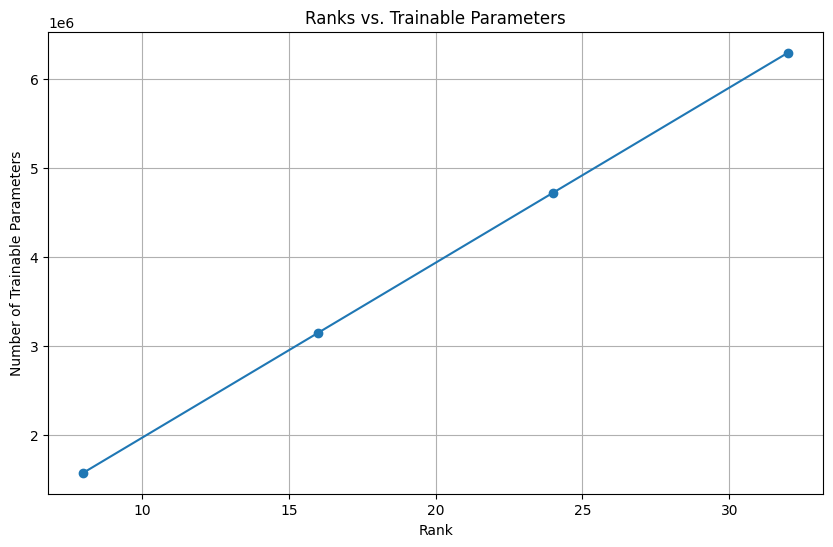

In [31]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(ranks, parameters, marker='o')
plt.title('Ranks vs. Trainable Parameters')
plt.xlabel('Rank')
plt.ylabel('Number of Trainable Parameters')
plt.grid(True)
plt.show()


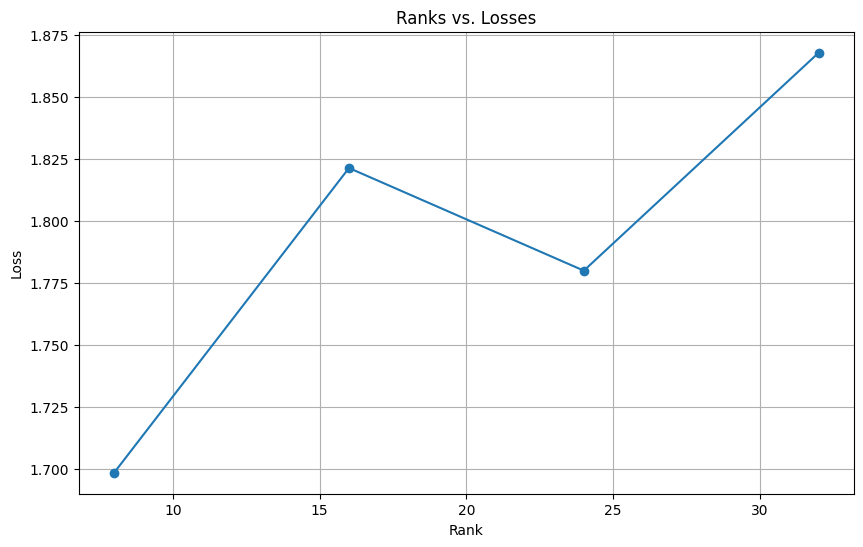

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(ranks, losses, marker='o')
plt.title('Ranks vs. Losses')
plt.xlabel('Rank')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


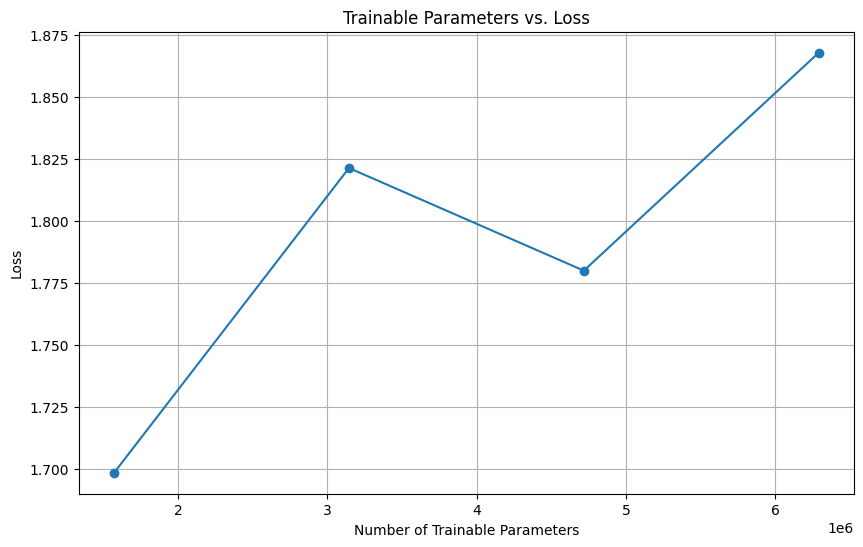

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(parameters, losses, marker='o')
plt.title('Trainable Parameters vs. Loss')
plt.xlabel('Number of Trainable Parameters')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


## KD - Classificador de Sentenças


In [34]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.optim as optim

from sklearn.model_selection import train_test_split

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
classification_dataset = load_dataset("gtalasso/dataset_classification")

In [37]:
# Load teacher model and tokenizer (pre-trained for sentiment analysis)
model_path = 'gtalasso/bert_dataset_classifier'

tokenizer = AutoTokenizer.from_pretrained(model_path)
teacher_model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)


if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [38]:
my_config = DistilBertConfig(n_heads=2, n_layers=2, num_labels=3)

student_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                                    config=my_config).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding='max_length', truncation=True)

# Tokenize all datasets
tokenized_data = classification_dataset.map(preprocess_function, batched=True)
tokenized_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'source_dataset'])

# Rename 'label' to 'labels' to match the expected format
#tokenized_data = tokenized_data.rename_column("label", "labels")

In [40]:
def process_source_dataset(example):
    teacher_dict = {'google/boolq': 0, 'gretelai/synthetic_text_to_sql': 1, 'sh0416/ag_news': 2}
    example['source_dataset'] = teacher_dict[example['source_dataset']]
    return example

tokenized_data = tokenized_data.map(process_source_dataset)



In [41]:
#tokenized_data.shuffle()
#tokenized_data['train'], tokenized_data['test'] = tokenized_data['train'][0:120], tokenized_data['train'][120:-1]

In [42]:
# Split the dataset using the `select` method
tokenized_data.shuffle()
train_indices = list(range(120))
test_indices = list(range(120, len(tokenized_data['train'])))

tokenized_data_base = tokenized_data.copy()

tokenized_data['train'] = tokenized_data_base['train'].select(train_indices)
tokenized_data['test'] = tokenized_data_base['train'].select(test_indices)

In [43]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['text', 'source_dataset', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 120
    })
    test: Dataset({
        features: ['text', 'source_dataset', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30
    })
})

In [44]:
# Function to evaluate model performance
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Disable gradient calculations
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['source_dataset'].to(device)

            # Forward pass to get logits
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Get predictions
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1

In [45]:
# Function to compute distillation and hard-label loss
def distillation_loss(student_logits, teacher_logits, true_labels, temperature, alpha):
    # Compute soft targets from teacher logits
    soft_targets = nn.functional.softmax(teacher_logits / temperature, dim=1)
    student_soft = nn.functional.log_softmax(student_logits / temperature, dim=1)

    # KL Divergence loss for distillation
    distill_loss = nn.functional.kl_div(student_soft, soft_targets, reduction='batchmean') * (temperature ** 2)

    # Cross-entropy loss for hard labels
    hard_loss = nn.CrossEntropyLoss()(student_logits, true_labels)

    # Combine losses
    loss = alpha * distill_loss + (1.0 - alpha) * hard_loss

    return loss

In [46]:
batch_size = 8
lr = 1e-3  # Lower learning rate for sentiment analysis
num_epochs = 10
temperature = 1
alpha = 0.8
max_steps = 100

# define optimizer
optimizer = optim.Adam(student_model.parameters(), lr=lr)

# create training data loader
train_dataloader = DataLoader(tokenized_data['train'], batch_size=batch_size, shuffle=True)
# create testing data loader
test_dataloader = DataLoader(tokenized_data['test'], batch_size=batch_size)

# put student model in train mode
student_model.train()

# train model
print("Training student model:")
global_step = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} ---")
    total_loss = 0
    epoch_steps = 0
    for batch in train_dataloader:
        # Prepare inputs
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['source_dataset'].to(device)

        # Disable gradient calculation for teacher model
        with torch.no_grad():
            teacher_outputs = teacher_model(input_ids, attention_mask=attention_mask)
            teacher_logits = teacher_outputs.logits

        # Forward pass through the student model
        student_outputs = student_model(input_ids, attention_mask=attention_mask)
        student_logits = student_outputs.logits

        # Compute the distillation loss
        loss = distillation_loss(student_logits, teacher_logits, labels, temperature, alpha)

        total_loss += loss.item()
        epoch_steps += 1
        global_step += 1

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if global_step >= max_steps:
            break

        if global_step % 10 == 0:
            print(f"Step {global_step} - Loss: {loss.item():.4f}")

    avg_loss = total_loss / epoch_steps
    print(f"Epoch {epoch + 1} completed with average loss: {avg_loss:.4f}")

    # Evaluate the teacher model
    teacher_accuracy, teacher_precision, teacher_recall, teacher_f1 = evaluate_model(teacher_model, test_dataloader, device)
    print(f"Teacher (val) - Accuracy: {teacher_accuracy:.4f}, Precision: {teacher_precision:.4f}, Recall: {teacher_recall:.4f}, F1 Score: {teacher_f1:.4f}")

    # Evaluate the student model
    student_accuracy, student_precision, student_recall, student_f1 = evaluate_model(student_model, test_dataloader, device)
    print(f"Student (val) - Accuracy: {student_accuracy:.4f}, Precision: {student_precision:.4f}, Recall: {student_recall:.4f}, F1 Score: {student_f1:.4f}")
    print("\n")

    # Put student model back into train mode
    student_model.train()

    if global_step >= max_steps:
        break

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1} completed with average loss: {avg_loss:.4f}")

    # Evaluate the teacher model
    teacher_accuracy, teacher_precision, teacher_recall, teacher_f1 = evaluate_model(teacher_model, test_dataloader, device)
    print(f"Teacher (val) - Accuracy: {teacher_accuracy:.4f}, Precision: {teacher_precision:.4f}, Recall: {teacher_recall:.4f}, F1 Score: {teacher_f1:.4f}")

    # Evaluate the student model
    student_accuracy, student_precision, student_recall, student_f1 = evaluate_model(student_model, test_dataloader, device)
    print(f"Student (val) - Accuracy: {student_accuracy:.4f}, Precision: {student_precision:.4f}, Recall: {student_recall:.4f}, F1 Score: {student_f1:.4f}")
    print("\n")

    # put student model back into train mode
    student_model.train()

Training student model:
Epoch 1 ---
Step 10 - Loss: 0.4337
Epoch 1 completed with average loss: 0.6484
Teacher (val) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Student (val) - Accuracy: 0.9000, Precision: 1.0000, Recall: 0.9000, F1 Score: 0.9474


Epoch 1 completed with average loss: 0.6484
Teacher (val) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Student (val) - Accuracy: 0.9000, Precision: 1.0000, Recall: 0.9000, F1 Score: 0.9474


Epoch 2 ---
Step 20 - Loss: 0.3732
Step 30 - Loss: 0.3838
Epoch 2 completed with average loss: 0.2977
Teacher (val) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Student (val) - Accuracy: 0.7333, Precision: 1.0000, Recall: 0.7333, F1 Score: 0.8462


Epoch 2 completed with average loss: 0.2977
Teacher (val) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Student (val) - Accuracy: 0.7333, Precision: 1.0000, Recall: 0.7333, F1 Score: 0.8462


Epoch 3 ---

In [47]:
#Final Evaluation:

# Evaluate the teacher model
teacher_accuracy, teacher_precision, teacher_recall, teacher_f1 = evaluate_model(teacher_model, test_dataloader, device)
print(f"Teacher (final) - Accuracy: {teacher_accuracy:.4f}, Precision: {teacher_precision:.4f}, Recall: {teacher_recall:.4f}, F1 Score: {teacher_f1:.4f}")

# Evaluate the student model
student_accuracy, student_precision, student_recall, student_f1 = evaluate_model(student_model, test_dataloader, device)
print(f"Student (final) - Accuracy: {student_accuracy:.4f}, Precision: {student_precision:.4f}, Recall: {student_recall:.4f}, F1 Score: {student_f1:.4f}")

Teacher (final) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Student (final) - Accuracy: 0.6000, Precision: 1.0000, Recall: 0.6000, F1 Score: 0.7500


In [48]:
# Helper function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

teacher_params = count_parameters(teacher_model)
student_params = count_parameters(student_model)

print(f"Teacher model parameters: {teacher_params:,}")
print(f"Student model parameters: {student_params:,}")
print(f"Size reduction: {(1 - student_params/teacher_params) * 100:.2f}%")

Teacher model parameters: 109,484,547
Student model parameters: 38,604,291
Size reduction: 64.74%


In [49]:
student_model.save_pretrained('output/student_model')

## Multi-LoRA

In [50]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    pipeline,
    BitsAndBytesConfig
)
from peft import PeftModel, PeftConfig
from datasets import load_dataset
import torch

#from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, AutoTokenizer, , TrainingArguments

In [51]:
classification_dataset = load_dataset("gtalasso/dataset_classification")
boolq_dataset = load_dataset("google/boolq")
agnews_dataset = load_dataset("sh0416/ag_news")
sql_dataset = load_dataset("gretelai/synthetic_text_to_sql")

In [52]:
if IN_COLAB:

    lora_boolq_path = '/content/drive/MyDrive/Curso_IA/modulo_2/output/Qlora/boolq/checkpoint-20'
    lora_agnews_path = '/content/drive/MyDrive/Curso_IA/modulo_2/output/Qlora/agnews/checkpoint-20'
    lora_sql_path = '/content/drive/MyDrive/Curso_IA/modulo_2/output/Qlora/sql/checkpoint-20'
    classifier_path = '/content/drive/MyDrive/Curso_IA/modulo_2/output/student_model'
else:
    lora_boolq_path = 'output/Qlora/boolq/checkpoint-20'
    lora_agnews_path = 'output/Qlora/agnews/checkpoint-20'
    lora_sql_path = 'output/Qlora/sql/checkpoint-20'
    classifier_path = 'output/student_model'

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [54]:
class MultiLoRA:
    def __init__(self, config):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Carregar classificador
        #model_path =

#tokenizer = AutoTokenizer.from_pretrained('gtalasso/bert_dataset_classifier')
        self.classifier_tokenizer = AutoTokenizer.from_pretrained('gtalasso/bert_dataset_classifier')#AutoTokenizer.from_pretrained(config['classifier_path'])
        classifier_base_model = AutoModelForSequenceClassification.from_pretrained(
            config['classifier_path'],#.base_model_name_or_path,
            num_labels=config['num_tasks'],
            local_files_only=True
        )
        #self.classifier = PeftModel.from_pretrained(
        #    classifier_base_model,
        #    config['classifier_path']
        #).to(self.device)

        self.classifier = classifier_base_model.to(self.device)

        # Mapeamento de labels para tarefas
        self.id2task = config['id2task']

        # Carregar modelo base principal

        quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_storage=torch.bfloat16
        )


        self.base_model = AutoModelForCausalLM.from_pretrained(
            config['base_model_name'],
            device_map="auto",
            quantization_config=quant_config
        )
        self.model_tokenizer = AutoTokenizer.from_pretrained(config['base_model_name'])
        self.model_tokenizer.pad_token = self.model_tokenizer.eos_token

        # Carregar adaptadores LoRA
        self.adapters = config['adapters']
        for task, adapter_path in self.adapters.items():
            self.base_model.load_adapter(adapter_path, adapter_name=task)


    def classify_task(self, text):
        relevant_text = ''
        try:
            relevant_text = text.split("### Response:")[0]
        except:
            relevant_text = text

        inputs = self.classifier_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        ).to(self.device)['input_ids']

        with torch.no_grad():
            logits = self.classifier(inputs).logits

        task_id = torch.argmax(logits).item()
        return self.id2task[task_id]

    def generate_response(self, text, task):
        # Ativar adapter correspondente
        print(task)
        self.base_model.set_adapter(task)

        #text = self.format_text(sample, task)

        # Configurar pipeline de geração
        if task == 'agnews':


          generator = pipeline(
            "text-generation",
            model=self.base_model,
            tokenizer=self.model_tokenizer,
            #device=self.device
        )
        elif task == 'boolq':
          generator = pipeline(
              'text-generation',
              model=self.base_model,
              tokenizer=self.model_tokenizer,
              #device=self.device
          )

        else:
          generator = pipeline(
              "text-generation",
              model=self.base_model,
              tokenizer=self.model_tokenizer,
              #device=self.device
          )

        # Parâmetros de geração
        response = generator(
            text,
            #max_length=256,
            #temperature=0.7,
            #top_p=0.9,
            do_sample=True,
            num_return_sequences=1
        )


        '''response = self.base_model.generate(
                input_ids=self.model_tokenizer(text),
                max_new_tokens=256,
                do_sample=True,
                temperature=0.7,
                top_k=50,
                top_p=0.95
        )'''


        return response[0]['generated_text']

    def __call__(self, input_text):
        # Classificar a entrada
        task = self.classify_task(input_text)

        # Gerar resposta especializada
        return self.generate_response(input_text, task)

# Configuração de exemplo
config = {
    "classifier_path": classifier_path,
    "base_model_name": 'HuggingFaceTB/SmolLM-1.7B',
    "num_tasks": 3,
    "id2task": {
        0: "boolq",
        2: "sql",
        1: "agnews"
    },
    "adapters": {
        "boolq": lora_boolq_path,
        "sql": lora_sql_path,
        "agnews": lora_agnews_path
    }
}



In [55]:
multi_lora = MultiLoRA(config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [56]:
def format_text(sample, task):
      match task:
        case 'boolq':
          return f"Passage: {sample['passage']} Question: {sample['question']} ### Response:\n"
        case 'sql':
          return f"### SQL Prompt:\n{sample['sql_prompt']}\n### Response:\n"
        case 'agnews':
          return f"Title: {sample['title']} ### Response:\n"

In [57]:
# Uso
question = boolq_dataset['train'][0]
text = format_text(question, 'boolq')
print(text)
multi_lora(text)


Device set to use cuda:0


Passage: Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet. Question: do iran and afghanistan speak the same language ### Response:

boolq


'Passage: Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet. Question: do iran and afghanistan speak the same language ### Response:\n- 👉 📄 795 💬 Response: FASL '

In [58]:
question = agnews_dataset['train'][0]
text = format_text(question, 'agnews')
print(text)
multi_lora(text)

Device set to use cuda:0


Title: Wall St. Bears Claw Back Into the Black (Reuters) ### Response:

boolq


'Title: Wall St. Bears Claw Back Into the Black (Reuters) ### Response:\n05 Jul 20, 2:15 PM GMT\n1. The article doesn'

In [59]:
question = sql_dataset['train'][0]
text = format_text(question, 'sql')
print(text)
multi_lora(text)

Device set to use cuda:0


### SQL Prompt:
What is the total volume of timber sold by each salesperson, sorted by salesperson?
### Response:

agnews


'### SQL Prompt:\nWhat is the total volume of timber sold by each salesperson, sorted by salesperson?\n### Response:\n\nThis question asked for the total volume of timber shipped by each salesperson (or, in other'